In [3]:
''' Import packages. '''
# Time packages
import calendar, cftime, datetime, time
# Numerical analysis packages
import numpy as np, random, scipy, numba
# Local data storage packages
import functools, importlib, os, pickle, collections, sys

import pandas as pd, xarray as xr, nc_time_axis
xr.set_options(keep_attrs=True)
# Visualization tools
import cartopy, cartopy.util as cutil, cartopy.crs as ccrs, matplotlib, matplotlib.pyplot as plt

import analysis, visualization_aqp
importlib.reload(analysis)
importlib.reload(visualization_aqp)

# Local imports
sys.path.insert(1, '/projects/GEOCLIM/gr7610/scripts')
import derived, utilities, visualization, track_TCs, tc_analysis
importlib.reload(track_TCs);
importlib.reload(tc_analysis);

### Northward transport of a scalar, $a$

#### Operators
- $\left( \overline{\bullet} \right)$: time mean
- $\left[ \bullet \right]$: zonal mean
- $\left( \bullet \right)'$: anomaly from time mean
- $\left( \bullet \right)^*$: anomaly from zonal mean
  
#### Equation
#### $\left[ \overline{va} \right] = \underbrace{\left[ \overline{v} \right] \left[ \overline{a} \right]}_{\mathrm{MMC}} + \underbrace{\left[ \overline{v^*} \overline{a^*} \right]}_{\mathrm{SE}} + \underbrace{\left[ \overline{v'a'} \right]}_{\mathrm{TE}} $

#### Terms
- $v$ is the meridional component of wind
- $a$ is a scalar
- $\mathrm{MMC}$ = transport from mean meridional circulation
- $\mathrm{SE}$ = transport from stationary eddies
- $\mathrm{TE}$ = transport from transient eddies

In [4]:
def check_data_contents(dataset: xr.Dataset,
                        target_field_name: str,
                        dimension_names: list[str],
                        field_names: list[str]):

    ''' Helper function to check for dimensions and field names for a derived-field calculation. '''

    assert isinstance(target_field_name, str), 'The target field name must be a string.'
    # Perform dimension checks
    assert isinstance(dimension_names, list), f'Dimension names must be provided in a list format.'
    for dimension_name in dimension_names:
        assert dimension_name in dataset.dims, f'Dimension name {dimension_name} must be in the dataset to calculate {target_field_name}.'
        
    # Perform field name checks
    assert isinstance(field_names, list), f'Field names must be provided in a list format.'
    for field_name in field_names:
        assert field_name in dataset.data_vars, f'Field name {field_name} must be in the dataset to calculate {target_field_name}.'

In [5]:
def get_geopotential(dataset: xr.Dataset) -> xr.Dataset:

    ''' 
    Function to calculate geopotential height for a given dataset. 
    
    Note: pressure indexing begins from the uppermost atmospheric pressure level.
    '''

    # Check for proper dimensions and field names
    dimension_names = ['pfull']
    field_names = ['temp', 'sphum']
    check_data_contents(dataset, target_field_name='geopotential', dimension_names=dimension_names, field_names=field_names)

    # Sort by descending pressure level (lowest pressure = zeroth index)
    dataset = dataset.sortby('pfull')

    # Get mixing ratio
    w = dataset['sphum'] / (1 - dataset['sphum'])
    # Get virtual temperature (Tv)
    T_v = dataset['temp'] * (w + utilities.get_constants('eps')) / (utilities.get_constants('eps') * (1 + w))
    # Get pressure differentials (dp) and convert from hPa to Pa
    dp = dataset.pfull.diff('pfull') * 100
    # Vertical indexing range (this chooses pressure levels starting on the second index)
    # By choosing this, it sets the integral limits (p1 and p2) to be ~5 hPa and ~1000 hPa
    vertical_range = range(1, len(dp) + 1)

    # Calculate integral components (note the unit correction for pressure, p)
    # Note the reversed cumulative sum - this is for height only
    integrand = (T_v.isel(pfull=vertical_range) / (dataset.pfull.isel(pfull=vertical_range) * 100)) * dp
    integral = integrand.sortby('pfull', ascending=False).cumsum('pfull')

    # Generate the xArray Dataset pertaining to geopotential heights
    dataset['phi'] = (utilities.get_constants('R_d') / utilities.get_constants('g')) * integral
    dataset['phi'].attrs = {'long_name': 'derived geopotential height',
                            'units': 'm$^2$ s$^{-2}$'}
    
    return dataset

In [6]:
def get_dse(dataset: xr.Dataset) -> xr.Dataset:

    ''' Function to calculate dry static energy for a given dataset. '''

    # Check for proper dimensions and field names
    dimension_names = ['pfull']
    field_names = ['temp', 'phi']
    check_data_contents(dataset, target_field_name='DSE', dimension_names=dimension_names, field_names=field_names)

    # Generate the xArray Dataset pertaining to geopotential heights
    dataset['s'] = utilities.get_constants('c_p') * dataset['temp'] + dataset['phi']
    dataset['s'].attrs = {'long_name': 'dry static energy',
                       'units': 'm$^2$ s$^{-2}$'}
    
    return dataset

In [7]:
def get_lq(dataset: xr.Dataset) -> xr.Dataset:

    ''' Function to calculate latent energy for a given dataset. '''

    # Check for proper dimensions and field names
    dimension_names = ['pfull']
    field_names = ['sphum']
    check_data_contents(dataset, target_field_name='lq', dimension_names=dimension_names, field_names=field_names)

    # Generate the xArray Dataset pertaining to geopotential heights
    dataset['lq'] = utilities.get_constants('L_v') * dataset['sphum']
    dataset['lq'].attrs = {'long_name': 'latent energy',
                           'units': 'm$^2$ s$^{-2}$'}
    
    return dataset

In [8]:
def get_time_anom(dataset: xr.Dataset) -> xr.Dataset:

    ''' Get the temporal anomaly for a DataArray. '''
    
    assert 'time' in dataset.dims, f'Time must be an axis to compute time anomalies.'

    # Get the mean per month
    monthly_mean = dataset.groupby('time.month').mean()
    # Initialize a container list to collect monthly anomalies
    monthly_anoms = []
    # Iterate over all months to calculate daily anomalies from monthly data
    for month in monthly_mean.month.values:
        monthly_data = dataset.sel(time=(dataset.time.dt.month == month))
        monthly_anom = monthly_data - monthly_mean.sel(month=month)
        monthly_anoms.append(monthly_anom)
    # Concatenate all anomalies
    monthly_anoms = xr.concat(monthly_anoms, dim='time')
    
    return monthly_anoms

In [9]:
def decompose_meridional_transport(dataset: xr.Dataset,
                                   target_field_name: str) -> xr.Dataset:

    ''' Function to decompose meridional transport into subcomponents, as in Hartmann (2006). '''

    # Check for proper dimensions and field names
    dimension_names = ['grid_xt', 'grid_yt', 'pfull']
    field_names = ['vcomp', target_field_name]
    check_data_contents(dataset, target_field_name=target_field_name, dimension_names=dimension_names, field_names=field_names)

    # Define helper functions
    get_zonal_mean = lambda a: a.mean(dim='grid_xt')
    get_time_mean = lambda a: a.mean(dim='time')
    get_monthly_mean = lambda a: a.groupby('time.month').mean()
    get_zonal_anom = lambda a: a - get_zonal_mean(a)

    ''' Define component-specific functions. '''
    # Mean meridional circulation (MMC) contributions
    get_mmc = lambda a, b: get_zonal_mean(get_monthly_mean(a)) * get_zonal_mean(get_monthly_mean(b))
    # Stationary eddy (SE) contributions
    get_se = lambda a, b: get_zonal_mean(get_monthly_mean(get_zonal_anom(a)) * get_monthly_mean(get_zonal_anom(b)))
    # Transient eddy (TE) contributions
    get_te = lambda a, b: get_zonal_mean(get_monthly_mean(get_time_anom(a) * get_time_anom(b)))
    
    dataset[f'{target_field_name}_mmc'] = get_mmc(dataset['vcomp'], dataset[target_field_name])
    print('Mean meridional circulation contribution computed.')
    dataset[f'{target_field_name}_se'] = get_se(dataset['vcomp'], dataset[target_field_name])
    print('Stationary eddy contribution computed.')
    dataset[f'{target_field_name}_te'] = get_te(dataset['vcomp'], dataset[target_field_name])
    print('Transient eddy contribution computed.')

    return dataset

In [10]:
def get_meridional_transport(dataset: xr.Dataset,
                             target_field_name: str) -> xr.Dataset:

    ''' 
    Function to derive the meridional transport for a given field. 
    '''
    
    # Check for proper dimensions and field names
    dimension_names = ['pfull']
    field_names = [target_field_name, 'vcomp']
    check_data_contents(dataset, target_field_name=target_field_name, dimension_names=dimension_names, field_names=field_names)

     # Ensure target field is a string has a vertical coordinate
    assert 'pfull' in dataset[target_field_name].dims, f'Field {target_field_name} must be a string.'

    # Sort by descending pressure level (lowest pressure = zeroth index)
    dataset = dataset.sortby('pfull')
    # Get pressure differentials (dp) and convert from hPa to Pa
    dp = dataset.pfull.diff('pfull') * 100
    # Vertical indexing range (this chooses pressure levels starting on the second index)
    # By choosing this, it sets the integral limits (p1 and p2) to be ~5 hPa and ~1000 hPa
    vertical_range = range(1, len(dp) + 1)

    print(f'[get_meridional_transport] target field name: {target_field_name}')
    integrand = np.cos(latitude_radians) * dataset[target_field_name].isel(pfull=vertical_range).mean('grid_xt') * dataset['vcomp'].isel(pfull=vertical_range).mean('grid_xt') * dp
    # Get integral value
    integral = integrand.sum(dim='pfull')

    # Get latitudes in radians
    latitude_radians = np.deg2rad(integral.grid_yt)
    # Define the constant for transport on a sphere
    const = 2 * np.pi * utilities.get_constants('a') / utilities.get_constants('g')

    # Generate the xArray Dataset pertaining to the target field name
    dataset[f'{target_field_name}_mt'] = const * integral
    dataset[f'{target_field_name}_mt'].attrs = {'long_name': f'meridional transport of {target_field_name}',
                                                'units': f'kg s^{-1} * {dataset[target_field_name].attrs["units"]}'}

    return dataset

In [11]:
def get_vertical_integral(dataset: xr.Dataset,
                          target_field_name: str) -> xr.Dataset:

    ''' 
    Function to vertically-integrate a given field with a vertical coordinate. 
    
    Note: pressure indexing begins from the uppermost atmospheric pressure level.
    '''
    
    # Check for proper dimensions and field names
    dimension_names = ['pfull']
    field_names = [target_field_name]
    check_data_contents(dataset, target_field_name=target_field_name, dimension_names=dimension_names, field_names=field_names)
    
    # Ensure target field is a string has a vertical coordinate
    assert 'pfull' in dataset[target_field_name].dims, f'Field {target_field_name} must be a string.'

    # Sort by descending pressure level (lowest pressure = zeroth index)
    dataset = dataset.sortby('pfull')
    # Get pressure differentials (dp) and convert from hPa to Pa
    dp = dataset.pfull.diff('pfull') * 100
    # Get column mass for quantity weighting
    # column_mass = dp.sum(dim='pfull') / utilities.get_constants('g')

    # Get integral
    integral = (dataset[target_field_name] * dp).sum(dim='pfull')

    # Generate the xArray Dataset pertaining to the target field name
    dataset[f'{target_field_name}_vi'] = integral / (utilities.get_constants('g'))
    dataset[f'{target_field_name}_vi'].attrs = {'long_name': f'vertical integral of {dataset[target_field_name].attrs['long_name']}',
                                                'units': {dataset[target_field_name].attrs['units']}}

    return dataset

#### Testing

In [10]:
dirname = '/scratch/gpfs/GEOCLIM/gr7610/tiger3/AM2.5/work/CTL1990s_tiger3_tiger3_intelmpi_24_540PE/POSTP'
filename = '01500101.atmos_mo.nc'
pathname = os.path.join(dirname, filename)

pressure_levels = [100, 200, 300, 400, 500, 700, 850, 900, 925, 950, 975, 1000]
data = xr.open_dataset(pathname)[['vcomp', 'sphum', 'temp']].sel(pfull=pressure_levels, method='nearest').load()

In [14]:
data = get_geopotential(dataset=data)
data = get_dse(dataset=data)
data = get_lq(dataset=data)

In [15]:
data['h'] = data['s'] + data['lq']

In [16]:
data = get_vertical_integral(dataset=data, target_field_name='h')

In [17]:
data = get_vertical_integral(dataset=data, target_field_name='s')

In [18]:
data = decompose_meridional_transport(dataset=data, target_field_name='s')

Mean meridional circulation contribution computed.
Stationary eddy contribution computed.
Transient eddy contribution computed.


In [19]:
data['s_trans'] = (data['s_mmc'] + data['s_se'] + data['s_te'])

In [20]:
data = get_vertical_integral(dataset=data, target_field_name='s_trans')

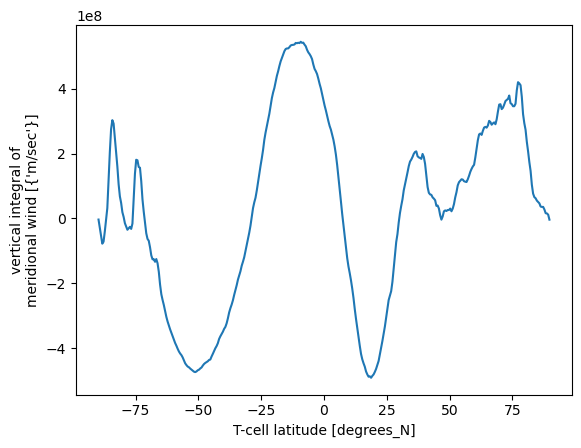

In [21]:
data['s_trans_vi'].mean('month').plot()

#### $\left[ \overline{va} \right] = \underbrace{\left[ \overline{v} \right] \left[ \overline{h} \right]}_{\mathrm{MMC}} + \underbrace{\left[ \overline{v^*} \overline{h^*} \right]}_{\mathrm{SE}} + \underbrace{\left[ \overline{v'h'} \right]}_{\mathrm{TE}} $

In [14]:
# MMC
h_bar = data['h'].groupby('time.month').mean()
v_bar = data['vcomp'].groupby('time.month').mean()

data['mmc'] = h_bar.mean('grid_xt') * v_bar.mean('grid_xt')
mmc = get_vertical_integral(data, 'mmc')['mmc_vi']

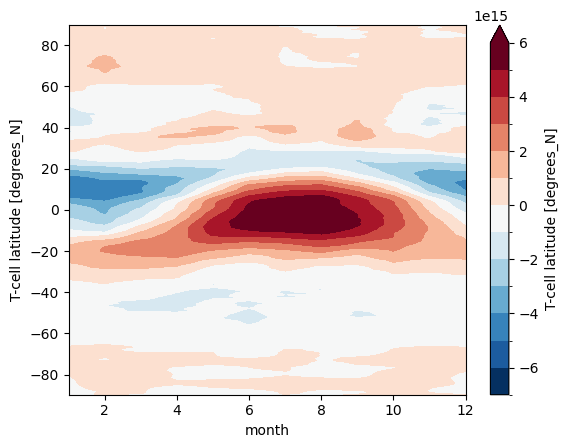

In [15]:
# Get latitudes in radians
latitude_radians = np.deg2rad(data.grid_yt)
# Define the constant for transport on a sphere
const = 2 * np.pi * utilities.get_constants('a') * np.cos(latitude_radians) / utilities.get_constants('g')

norm = matplotlib.colors.BoundaryNorm(np.arange(-7e15, 7e15, 1e15), 256)
(const * mmc).plot.contourf(x='month', norm=norm, cmap='RdBu_r')

In [16]:
# SE
# h_star = data['h'].groupby('time.month').mean() - (data['h'].groupby('time.month').mean()).mean('grid_xt')
h_star = (data['h'] - data['h'].mean('grid_xt')).groupby('time.month').mean()
# v_star = data['vcomp'].groupby('time.month').mean() - (data['vcomp'].groupby('time.month').mean()).mean('grid_xt')
v_star = (data['vcomp'] - data['vcomp'].mean('grid_xt')).groupby('time.month').mean()

data['se'] = (h_star * v_star).mean('grid_xt')
se = get_vertical_integral(data, 'se')['se_vi']

In [16]:
# TE
h_prime = (data['h'] - data['h'].go.mean('time'))

data['se'] = (h_star * v_star).mean('grid_xt')
se = get_vertical_integral(data, 'se')['se_vi']

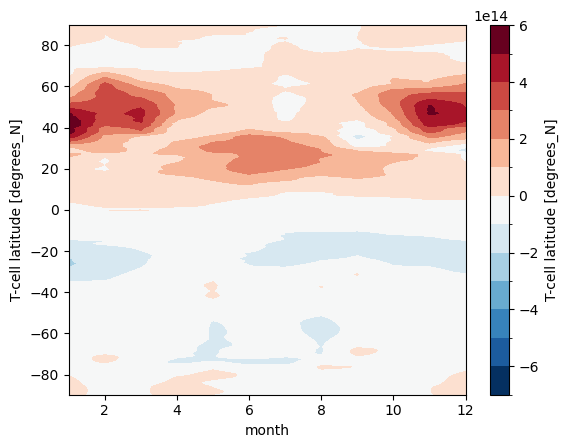

In [18]:
# Get latitudes in radians
latitude_radians = np.deg2rad(data.grid_yt)
# Define the constant for transport on a sphere
const = 2 * np.pi * utilities.get_constants('a') * np.cos(latitude_radians) / utilities.get_constants('g')

norm = matplotlib.colors.BoundaryNorm(np.arange(-7e14, 7e14, 1e14), 256)
(const * se).plot.contourf(x='month', norm=norm, cmap='RdBu_r')

### Overturning circulation

In [19]:
def generate_field_plot_data(data,
                             field_name,
                             averaging_dimensions: str | list[str],
                             contour_levels: int=8):
    
    average = data[field_name].mean(averaging_dimensions)
    norm, cmap = visualization.norm_cmap(average, field=field_name, num_bounds=contour_levels)

    return average, norm, cmap

In [20]:
data = utilities.meridional_overturning(data)

In [ ]:
data['psi_m'].cumsum(dim='pfull')

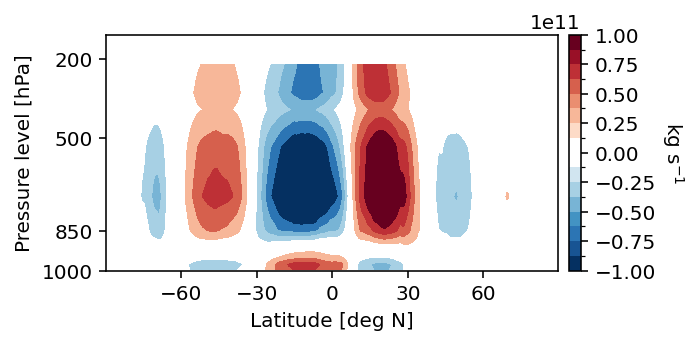

In [25]:
dataset_field_name = 'psi_m'
dataset, norm, cmap = generate_field_plot_data(data, 
                                               field_name=dataset_field_name, 
                                               averaging_dimensions=['time'],
                                               contour_levels=16)

fig, ax = plt.subplots(figsize=(5, 2.5), dpi=144)

# Plot baseline figure
ax.contourf(dataset.grid_yt, dataset.pfull, dataset.T, 
            norm=norm, cmap=cmap, levels=len(norm.boundaries))

cax = ax.inset_axes([1.025, 0, 0.025, 1])
colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, cmap), cax=cax)
long_name, units = visualization.field_properties(dataset_field_name)
colorbar.set_label(f'{units}', labelpad=15, rotation=270)

ax.set_xticks(np.arange(-60, 90, 30))
ax.set_yticks([200, 500, 850, 1000])

ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel('Latitude [deg N]')
ax.set_ylabel('Pressure level [hPa]')

fig.tight_layout()